Registri da 8 piedi dei dati analizzati.
L'organo può utilizzare diversi registri, in quale registro solo stati campionati i dati?
Classifico in base a registro--->unsupervised learning.
https://it.wikipedia.org/wiki/Registro_(organo)

In [599]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct, fft, rfft
from scipy.fftpack import fftfreq, rfftfreq
from scipy.io import wavfile
import pandas as pd
from scipy.signal import find_peaks, argrelextrema
from fractions import gcd
import math

In [600]:
# wavio.py
# Author: Warren Weckesser
# License: BSD 3-Clause (http://opensource.org/licenses/BSD-3-Clause)

import wave as _wave
import numpy as _np


def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = _np.empty((num_samples, nchannels, 4), dtype=_np.uint8)
        raw_bytes = _np.fromstring(data, dtype=_np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = _np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a WAV file.

    Parameters
    ----------
    file : string or file object
        Either the name of a file or an open file pointer.

    Return Values
    -------------
    rate : float
        The sampling frequency (i.e. frame rate)
    sampwidth : float
        The sample width, in bytes.  E.g. for a 24 bit WAV file,
        sampwidth is 3.
    data : numpy array
        The array containing the data.  The shape of the array is
        (num_samples, num_channels).  num_channels is the number of
        audio channels (1 for mono, 2 for stereo).

    Notes
    -----
    This function uses the `wave` module of the Python standard libary
    to read the WAV file, so it has the same limitations as that library.
    In particular, the function does not read compressed WAV files.

    """
    wav = _wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, array


def writewav24(filename, rate, data):
    """
    Create a 24 bit wav file.

    Parameters
    ----------
    filename : string
        Name of the file to create.
    rate : float
        The sampling frequency (i.e. frame rate) of the data.
    data : array-like collection of integer or floating point values
        data must be "array-like", either 1- or 2-dimensional.  If it
        is 2-d, the rows are the frames (i.e. samples) and the columns
        are the channels.

    Notes
    -----
    The data is assumed to be signed, and the values are assumed to be
    within the range of a 24 bit integer.  Floating point values are
    converted to integers.  The data is not rescaled or normalized before
    writing it to the file.

    Example
    -------
    Create a 3 second 440 Hz sine wave.

    >>> rate = 22050  # samples per second
    >>> T = 3         # sample duration (seconds)
    >>> f = 440.0     # sound frequency (Hz)
    >>> t = np.linspace(0, T, T*rate, endpoint=False)
    >>> x = (2**23 - 1) * np.sin(2 * np.pi * f * t)
    >>> writewav24("sine24.wav", rate, x)

    """
    a32 = _np.asarray(data, dtype=_np.int32)
    if a32.ndim == 1:
        # Convert to a 2D array with a single column.
        a32.shape = a32.shape + (1,)
    # By shifting first 0 bits, then 8, then 16, the resulting output
    # is 24 bit little-endian.
    a8 = (a32.reshape(a32.shape + (1,)) >> _np.array([0, 8, 16])) & 255
    wavdata = a8.astype(_np.uint8).tostring()

    w = _wave.open(filename, 'wb')
    w.setnchannels(a32.shape[1])
    w.setsampwidth(3)
    w.setframerate(rate)
    w.writeframes(wavdata)
    w.close()

In [658]:
path = "Organ/"
delta=20000

Uso la mono, prima colonna.

<ipython-input-600-f87b13984aa2>:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_bytes = _np.fromstring(data, dtype=_np.uint8)


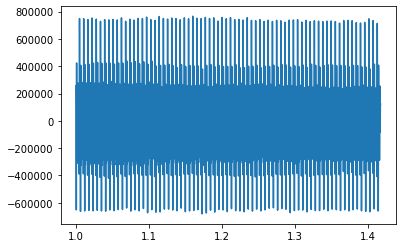

In [675]:
#prova per ciclare su tutti audio
n=str(4)
file = path + 'note_' + n
rate, data= readwav(file)
dati=data[rate:rate+delta,0]
t=np.linspace(1.0, 1.0 + delta/48000, delta)
plt.plot(t,data[rate:rate+delta,0])

In [676]:
df=pd.DataFrame((t,dati))
df=df.T

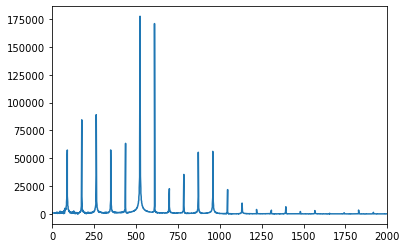

In [677]:
N=delta
samfreq=48000
T = 1.0 / samfreq

x = np.linspace(1.0, 1.0+ N*T, endpoint=False)
y = np.array(df[1])
yf = rfft(y)
xf = rfftfreq(N, T)[:N//2]
yfr= 2.0/N * np.abs(yf[0:N//2])
plt.plot(xf, yfr)
plt.xlim(0,2000)
plt.show()

In [679]:
#trovo i picchi con altezza maggiore di height
peaks, _ = find_peaks(yfr, height=15000)
#ricavo frequenze corrispondenti
maxfreq=xf[peaks]
#come calcolo il MCD?
#np.gcd.reduce(maxfreq)

#ecco le frequenze massime, in Herz, sembrano valori ragionevoli
#maxfreq=np.round(maxfreq)
rapporti=maxfreq/maxfreq[0]
rapporti=np.round(rapporti)
fond=maxfreq[0]

In [681]:
#per fare analisi per ogni file musicale!!

#inizializzo le variabili
delta=20000
N=delta
samfreq=48000
T = 1.0 / samfreq
x = np.linspace(1.0, 1.0+ N*T, endpoint=False)
h_picchi=15000
all_max=[]
all_rapporti=[]
fondam=[]
#gli audio sono 280, per prova uso numeri bassi, perchè dispendioso computazionalmente
num_audio=280

for i in range(1,num_audio):
    file = path + 'note_' + str(i)
    rate, data= readwav(file)
    dati=data[rate:rate+delta,0]
    df=pd.DataFrame((t,dati))
    df=df.T
    y = np.array(df[1])
    yf = rfft(y)
    xf = rfftfreq(N, T)[:N//2]
    yfr= 2.0/N * np.abs(yf[0:N//2])
    peaks, _ = find_peaks(yfr, height=h_picchi)
    maxfreq=xf[peaks]
    rapporti=maxfreq/maxfreq[0]
    rapporti=np.round(rapporti)
    fond=maxfreq[0]
    #devo calcolare il MCD delle maxfreq
    #non essendo numeri interi, come fare?
    
    #poi inserisco il mcd in una lista per ogni audio
    all_max.append(maxfreq)
    all_rapporti.append(rapporti)
    fondam.append(fond)

<ipython-input-600-f87b13984aa2>:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_bytes = _np.fromstring(data, dtype=_np.uint8)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [665]:
#le righe indicano il numero di brano analizzato
#per ogni brano segno i massimi in frequenza trovati
#alcuni brani hanno meno massimi, altri di piu
all_max=pd.DataFrame(all_max)
all_rapporti=pd.DataFrame(all_rapporti)
all_max

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1564.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,741.6,1483.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,165.6,496.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,88.8,175.2,261.6,348.0,436.8,523.2,609.6,698.4,784.8,871.2,957.6,1046.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110.4,220.8,331.2,552.0,662.4,772.8,1104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,331.2,991.2,1322.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,369.6,739.2,1106.4,1476.0,1845.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276,220.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,67.2,196.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
IPython.display.Audio(data[:1],rate=rate)

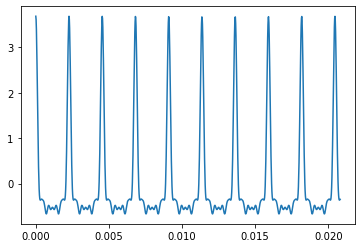

In [518]:
#notebook del prof
f0=440
t=np.arange(2*rate)/rate
overtones=[1,0.8,0.6,0.5,0.4,0.2,0.1,0.08]
x=np.zeros_like(t)
for k in range(len(overtones)):
    x+=overtones[k]*np.cos(2*f0*t*np.pi*(k+1))
    
plt.plot(t[0:1000],x[0:1000])

In [406]:
IPython.display.Audio(x,rate=rate)